---

<center><h2>Cargar librerias</h2></center>

---

In [36]:
#!pip install scikit-image

import os
import skimage
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import albumentations as A
from sklearn.decomposition import PCA

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN

In [2]:
#!pip uninstall skimage pandas numpy cv2 -y
#!pip install numpy

---

<center><h2>Leer imagenes del zip</h2></center>

---

In [3]:
def read_folder(path):
    files = [ os.path.join(path, file) for file in os.listdir(path) if file.endswith(".jpg") ]
    #return sorted(files, key=lambda name: int(name.split("/")[-1][:-4]))
    return files

def to_imgs(imgs):
    #return [skimage.io.imread(x) for x in imgs]
    return [cv2.imread(x) for x in imgs]

X_files = read_folder("../zip/train/")
Y_files = read_folder("../zip/test/")
Y_files = sorted(Y_files, key=lambda name: int(name.split("/")[-1][:-4])) # Para que esten en el mismo orden que y_clusters

X_imgs = to_imgs(X_files)
Y_imgs = to_imgs(Y_files)

# Cluster al que corresponde cada carta en test.zip
y_clusters = [ int(x) for x in open("../zip/test_clusters.txt").read().split(", ") ]

---

<center><h2>Preprocesamiento de imagenes</h2></center>

---

In [69]:
######################
# Plotting functions #
######################

# Plotear imagen
def plot_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    skimage.io.imshow(img)

# Plotear una comparacion de dos sets de imagenes, row es la fila a plotear
def plot_comparison(imgs1, imgs2, row=0):
  fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(30, 5))

  for x in range(10):
    img = cv2.cvtColor(imgs1[row*10 + x], cv2.COLOR_BGR2RGB)
    axs[0][x].imshow(img)
 
  for x in range(10):
    img = cv2.cvtColor(imgs2[row*10 + x], cv2.COLOR_BGR2RGB)
    axs[1][x].imshow(img)

# Plotear 10 filas
def plot_10_rows(imgs):
    rows, cols = 10, 10
    fig, axs = plt.subplots(rows, cols, figsize=(30, 50))
    
    for y in range(rows):
        for x in range(cols):
            axs[y][x].imshow(imgs[rows*y + x])

# Dibuja la curva de varianza de PCA
def plot_pca_variance(imgs_flat):
    pca = PCA()
    
    pca.fit_transform(imgs_flat)
    
    plt.grid()
    plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
    plt.xlabel('Numero de componentes')
    plt.ylabel('Varianza explicada')

def plot_cluster_clouds(imgs_flat, pred):
    import seaborn as sns
    pca = PCA(n_components=2)
    
    imgs_2d = pca.fit_transform(imgs_flat)
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
    ax = sns.scatterplot(x=imgs_2d[:,0], y=imgs_2d[:,1], palette="pastel", hue=pred, ax=ax)
    ax.set(xlabel="Componente 1", ylabel="Componente 2")
    #sns.xlabel('Number of components')
    #sns.ylabel('Explained variance')
            
##################
# File functions #
##################
def save_files(imgs, folder, files):
    files = [ f.split("/")[-1] for f in files ]
    
    for i, img in enumerate(imgs):
        cv2.imwrite(folder + files[i], img)

#save_files(X_imgs[:10], "../zip/test/", X_files)

In [5]:
##############################
# Cluster plotting functions #
##############################
def print_cluster_sizes(pred, y_clusters):
    print("Clusters:")
    for cluster in set(pred):
        print("  ", cluster, "size", len([_ for _ in pred if _ == cluster]))

    print("\nReal clusters:")
    for cluster in set(y_clusters):
        print("  ", cluster, "size", len([_ for _ in y_clusters if _ == cluster]))

    print()

def draw_clusters(imgs, pred):
    figheights = { 1: 5, 2: 7, 3: 10, 4: 15, 5: 16, 6: 20, 7: 25, 8: 28, 9: 30, 10: 35, 11: 40, 12: 45, 13: 50 }
    
    for targetClusterN in range(5):
        cluster_size = len([_ for _ in pred if _ == targetClusterN])
        nrows = cluster_size//10 + (1 if cluster_size%10 != 0 else 0)
        
        fig, axs = plt.subplots(ncols=10, nrows=nrows, figsize=(30, figheights[nrows]))
        fig.tight_layout()
        plt.figure(constrained_layout=True)
        
        # ax que va a tener el titulo
        title_ax = axs[0][0] if nrows > 1 else axs[0]
        title_ax.set_title("\nCluster " + str(targetClusterN) + "\n", fontsize=15)

        y, x = 0, 0

        for i, clusterN in enumerate(pred):
            if clusterN == targetClusterN:
                if nrows > 1: axs[y][x].imshow(imgs[i], aspect="auto")
                else: axs[x].imshow(imgs[i], aspect="auto")
                
                x += 1

            if x == 10:
                x = 0
                y += 1

In [6]:
############################
# Transformation functions #
############################
class Transformator:
    def __init__(self, img):
        self.img = img.copy()
        self.past = {}
    
    ################
    # Color spaces #
    ################
    def bgr_to_grayscale(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        #self.img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        
        return self
    
    def bgr_to_hsv(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        
        return self
    
    def grayscale_to_hsv(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_HSV2GRAY)
        
        return self
    
    def blur(self, val=(5, 5)):
        self.img = cv2.GaussianBlur(self.img, val, 0) # Parece funcionar bien
        #self.img = cv2.medianBlur(self.img, 5)
        #self.img = cv2.blur(self.img, val)
        #self.img = cv2.boxFilter(self.img, 5, 5) # No funciona
        
        #self.img = cv2.bilateralFilter(self.img, -1, 75, 75) # No termina
        
        return self
        
    def increase_contrast_brightness(self, contrast=1.0, brightness=0.0):
        self.img = contrast*self.img + brightness
        
        return self

    def increase_brightness(self, amt=20):
        hsv = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
    
        lim = 255 - amt
        v[v > lim] = 255
        v[v <= lim] += amt

        final_hsv = cv2.merge((h, s, v))
        self.img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    
        return self
    
    def denoise(self):
        #gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.img = cv2.fastNlMeansDenoisingColored(self.img, None, 20, 7, 21)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_RGB2BGR)
        #self.img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        #sigma_est = skimage.restoration.estimate_sigma(self.img, channel_axis=-1, average_sigmas=True)
        #imgs = skimage.util.random_noise(imgs, var=0.1
        #self.img = skimage.restoration.denoise_tv_chambolle(self.img, weight=0.1, channel_axis=-1)
        
        return self
    
    # experimental
    def remove_empty_space(self, treshold, limit_x, limit_y):
        backup = self.img.copy()
        
        # Horizontal
        while self.img.shape[1] > limit_x:
            left_col = self.img[:, 0]
            pixel_set = set()
            
            for pixel in left_col:
                pixel_set.add(tuple(pixel))
                
            if len(pixel_set) < treshold:
                self.img = self.img[:, 1:]
            else:
                break
        
        # Vertical
        while self.img.shape[0] > limit_y:
            #print(self.img.shape)
            top_row = self.img[0, :]
            pixel_set = set()
            
            for pixel in top_row:
                pixel_set.add(tuple(pixel))
                
            if len(pixel_set) < treshold:
                self.img = self.img[1:, :]
            else:
                break
        
        if self.img.shape[0] == 0:
            self.img = backup
        
        return self

    # Oscurecer zonas fuera de un determinado umbral
    def treshold_test(self, amt=1):
        gray_img = skimage.color.rgb2gray(self.img)
        blurred_img = skimage.filters.gaussian(gray_img, sigma=1.0)
    
        t = skimage.filters.threshold_otsu(blurred_img)
    
        binary_mask = blurred_img > t
        selection = self.img
        selection[~binary_mask] = 0
    
        self.img = selection
        
        return self
    
    def threshold(self):
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        
        self.img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        
        return self
    
    def threshold_and(self):
        gray = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        self.img = cv2.bitwise_and(self.img, self.img, mask=thresh)
        
        return self

    # Invertir los colores si es predominantemente negra
    # No funciona mucho.
    def invert_if_black(self, treshold=150):
        avg_color = self.img.mean(axis=0).mean(axis=0)
        
        if avg_color[0] + avg_color[1] < treshold or avg_color[0]+avg_color[2] < treshold or avg_color[1]+avg_color[2] < treshold:
            self.img = cv2.bitwise_not(self.img)
        
        return self
    
    # TODO: Todavia no actualiza el histograma
    def equalize_histogram(self):
        # Contrast stretching
        percentile_2, percentile_98 = np.percentile(self.img, (0, 100))
        self.img = skimage.exposure.rescale_intensity(self.img, in_range=(percentile_2, percentile_98))
        
        #self.img = cv2.normalize(self.img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        #self.img = skimage.exposure.equalize_hist(self.img)
        
        return self
    
    def resize(self, h=100, w=100):
        self.img = cv2.resize(self.img, (w, h)) 
        
        return self
    
    def remove_channel(self, channel=2):
        self.img[:,:,channel] = np.zeros([self.img.shape[0], self.img.shape[1]])
        
        return self
    
    def sobel(self):
        self.img = skimage.filters.sobel(self.img)
        
        return self
    
    ########################
    # Morphology functions #
    ########################
    def erode(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.erode(self.img, kernel, iterations=1)

        return self
    
    def dilate(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.dilate(self.img,kernel,iterations = 1)

        return self
    
    # erosion followed by dilation
    def opening(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.morphologyEx(self.img, cv2.MORPH_OPEN, kernel)
        
        return self
    
    # dilation followed by erosion
    def closing(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.morphologyEx(self.img, cv2.MORPH_CLOSE, kernel)
        
        return self
    
    def gradient(self):
        kernel = np.ones((5, 5), np.uint8)
        self.img = cv2.morphologyEx(self.img, cv2.MORPH_GRADIENT, kernel)
        
        return self
    
    ################
    # Segmentation #
    ################
    def segmentate(self):
        img = self.img

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

        # sure background area
        sure_bg = cv2.dilate(opening,kernel,iterations=3)

        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
        ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)

        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)
        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1
        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0

        markers = cv2.watershed(img,markers)
        img[markers == -1] = [255,0,0]

        self.img = img
        
        return self
    
    ######################
    # Recortar la imagen #
    ######################
    def crop(self, x1, x2, y1, y2):
        size = 224
        self.img = self.img[y1:y2, x1:x2]
        #self.img = self.img[0:50, :] + self.img[size-50:, :]
        #self.img = self.img[:, 0:50] + self.img[:, size-50:]
        
        return self
    
    def crop_from_red(self, x1, x2, y1, y2):
        size = 224
        img = self.img.copy()
        img = img[1:size-1, 1:size-1]
        
        while True:
            col = img[:, 0]
            
            if not (255, 0, 0) in col:
                img = img[:, 1:]
            else:
                break
        
        if img.shape[0] >= y2 and img.shape[1] >= x2:
            self.img = img
            self.crop(x1, x2, y1, y2)
        else:
            self.img = img[1:size-1, 1:size-1]
            self.crop(x1, x2, y1, y2)
        
        return self
    
    def crop_roi(self, _h, _w):
        #plot_image(X_imgs[100])
        img = self.img
        
        gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        im_gauss = cv2.GaussianBlur(gray_img, (5, 5), 0)
        ret, thresh = cv2.threshold(im_gauss, 127, 255, 0)

        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        #contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        rects = []
        for contour in contours[1:]:
            area=cv2.contourArea(contour)
            if area>=200:
                #cv2.drawContours(frame,[contour],0,(255,0,0),3)
                x,y,w,h=cv2.boundingRect(contour)
                rects.append((x, y, w, h))

                #cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)

        rects = sorted(rects, key=lambda t: t[0]+t[1])
                
        # No ha encontrado ninguna ROI
        if not rects:
            self.crop(0, _h, 0, _w)
        else:
            x, y, _, _ = rects[0]
            
            while y+_h >= 223: y -= 1
            while x+_w >= 223: x -= 1
            
            # Ha encontrado una ROI
            if y <= 0 or x <= 0:
                self.crop(0, _h, 0, _w)
            else:
                self.img = self.img[y:y+_h, x:x+_w]
            #print(self.img.shape)
            #else:
            #    self.crop(0, 0, _h, _w)
        
        return self
    
    @staticmethod
    def get_mask(img, black=([0, 0, 0], [100, 100, 100]), red=([80, 70, 50], [100, 255, 255])):       
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = img[:, :, 1]
        blur = cv2.GaussianBlur(img,(5, 5),1)
        
        #ret, th = cv2.threshold(blur, 120, 255, cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)
        #ret, th = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
        #ret, th = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
        #ret, th = cv2.threshold(img, 120, 255, cv2.THRESH_TRUNC)
        #ret, th = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO)
        #ret, th = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO_INV)
        
        #th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        #                                     cv2.THRESH_BINARY, 199, 5)

        th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                             cv2.THRESH_BINARY_INV, 199, 5)
        return th
    
    def remove_background(self):
        mask = Transformator.get_mask(self.img)
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2BGRA)
        
        self.img = cv2.bitwise_and(img, img, mask=mask)
        
        return self
    
    def bgr_to_rgb(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        return self


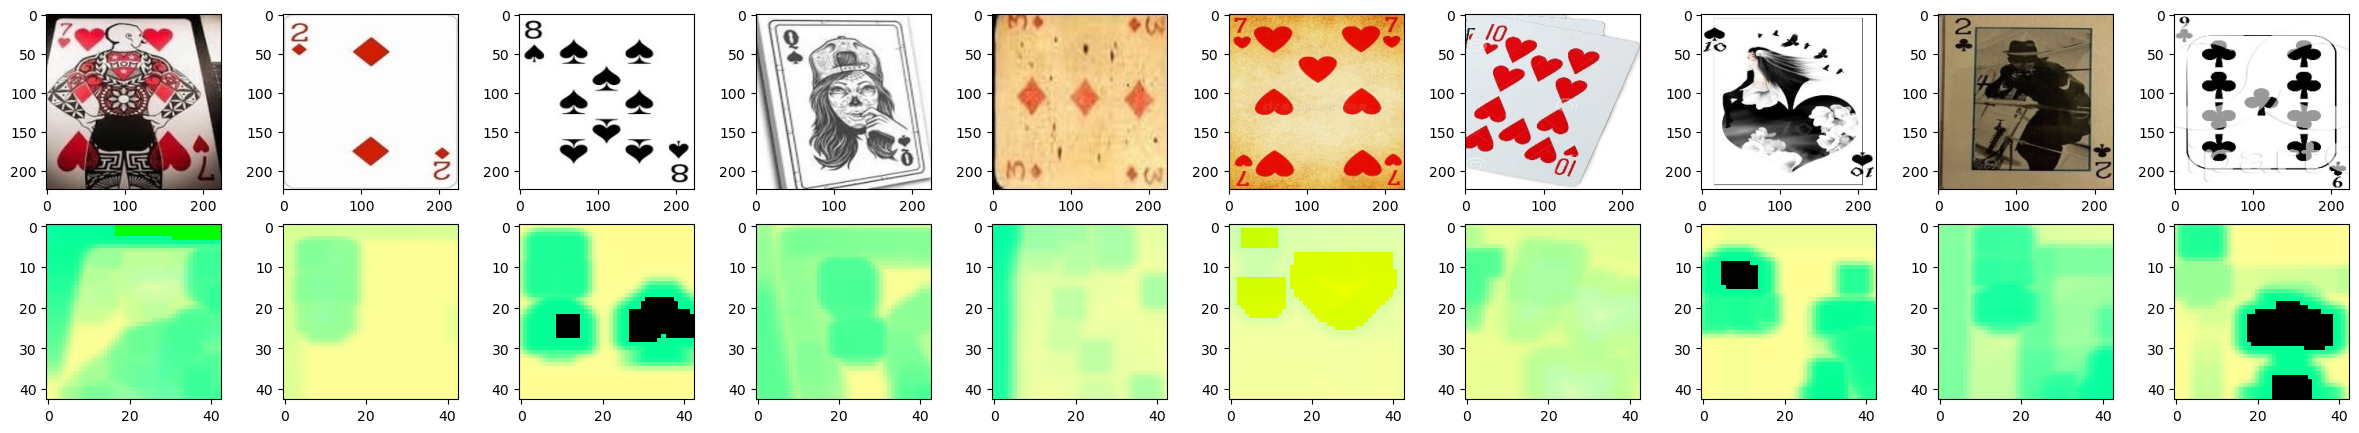

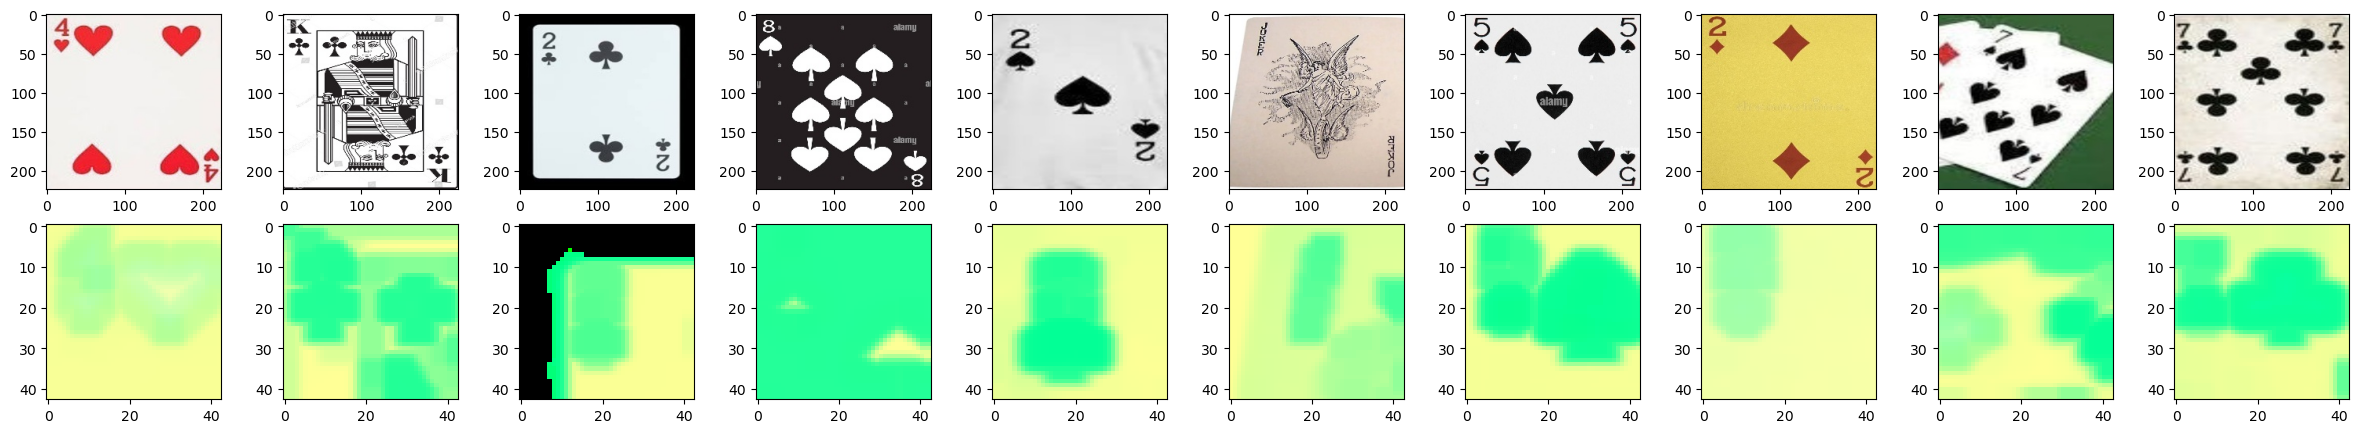

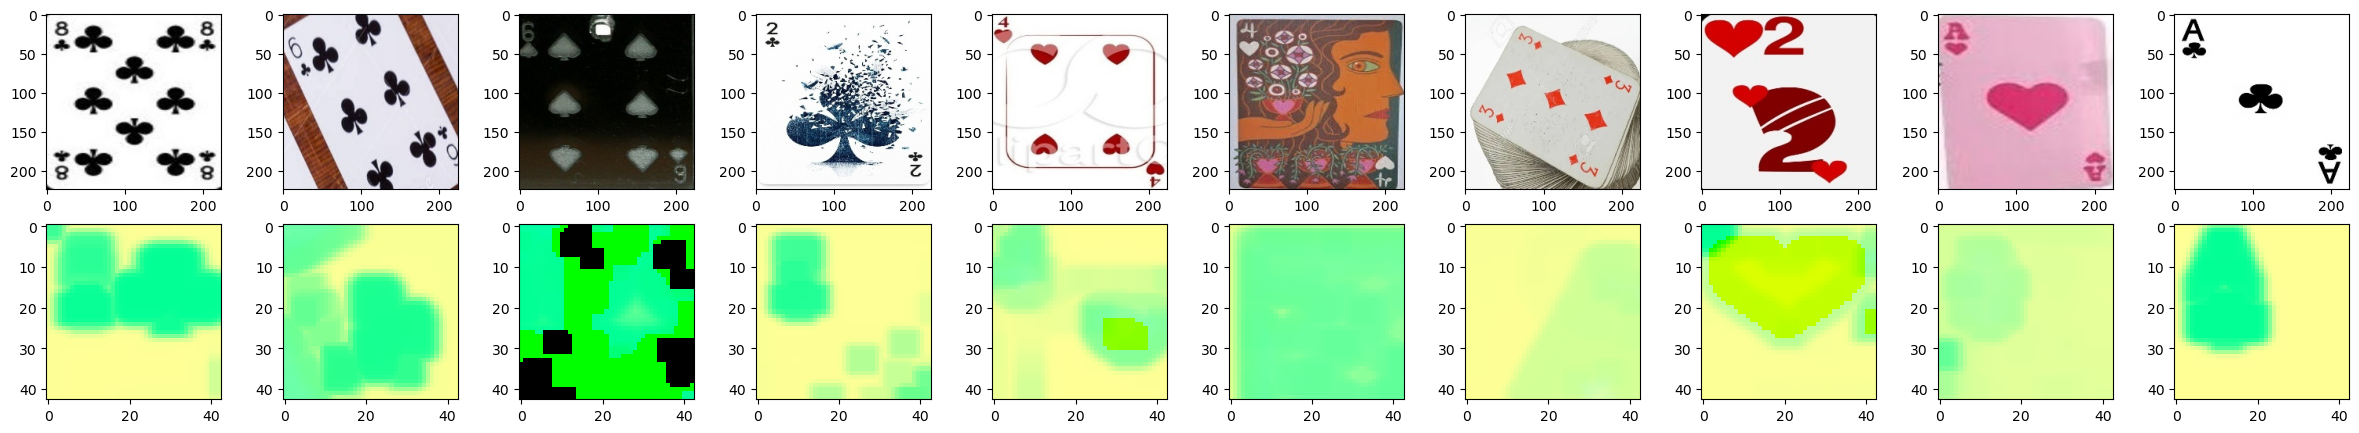

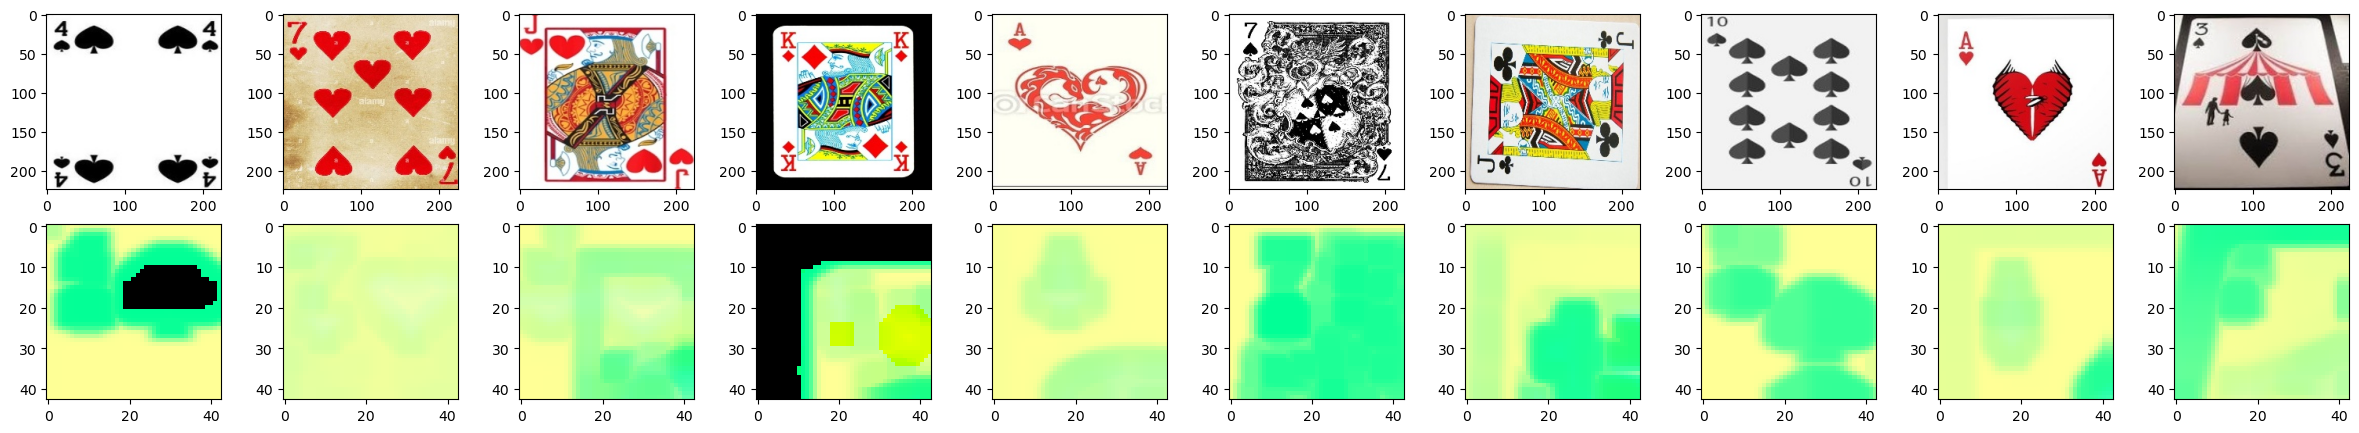

In [7]:
IMG_SIZE = 224

def rotate(img, degrees=90, zoom=1.0):
    M = cv2.getRotationMatrix2D((112, 112), -degrees, zoom)
    return cv2.warpAffine(img, M, (224, 224))

def augmentate_dataset(imgs):
    transform = A.Compose([
        #A.RandomCrop(width=30, height=30),
        #A.HorizontalFlip(p=1),
        #A.RandomRotate90(p=1)
        #A.SafeRotate(limit=90, p=1)
        A.ColorJitter( brightness=0.5,
                       contrast=0.5,
                       saturation=0.5,
                       hue=0.5)
        #A.ChannelShuffle(p=1)
        #A.VerticalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.2),
        #A.CLAHE(p=0.5),
        #A.InvertImg(p=0.1),
        #A.CenterCrop(height=50, p=1)
        #A.RandomBrightnessContrast(p=0.2),
    ])
    
    #return [img for img in imgs] + [ transform(image=img)["image"] for img in imgs ]
    return [ transform(image=img)["image"] for img in imgs ]
    #return [img for img in imgs] + [ rotate(img) for img in imgs ]
#    return imgs

#plot_image(x[0])
    
    return [img for img in imgs] + [ rotate(img) for img in imgs[:100] ]
      #+ [ cv2.flip(img, 1) for img in imgs[:100]]
      #+ [ skimage.util.random_noise(img, mode="gaussian", seed=None, clip=True) for img in imgs[:10] ]
    

def transform_imgs(imgs):
    CHANNEL_B, CHANNEL_G, CHANNEL_R = 0, 1, 2
    crop_x1, crop_x2 = 0, 30
    crop_y1, crop_y2 = 0, 33

    resize_h, resize_w = 112, 112

    treshold_empty_space = 10
    brightness_lv = 130
    
    # ndarray para que diga cuando no todas las imagenes tienen la misma forma
    return np.array([ Transformator(img)
        #.remove_background()
        #.resize(h=resize_h, w=resize_w)
        #.bgr_to_rgb()
        #.blur(val=(5, 3))
        #.erode()
        #.crop_roi(_h=100, _w=100)
        .remove_channel(CHANNEL_G)
        #.remove_empty_space(treshold=treshold_empty_space, limit_x=crop_x2, limit_y=crop_y2)
        #.grayscale()
        #.segmentate()
        #.crop(crop_x1, crop_x2, crop_y1, crop_y2)
        .blur(val=(5, 3))
        .erode()
        #.crop_from_red(crop_x1, crop_x2, crop_y1, crop_y2)
        #.blur(val=(5, 3))
        #.blur(val=(5, 3))
        .equalize_histogram()
        .resize(h=resize_h, w=resize_w)
        #.crop(crop_x1, crop_x2, crop_y1, crop_y2)
        #.bgr_to_grayscale()
        .blur(val=(5, 3))
        #.segmentate()
        #.bgr_to_hsv()
        .crop_roi(_h=43, _w=43)
        #.crop(crop_x1, crop_x2, crop_y1, crop_y2)
        #.opening()
        .bgr_to_hsv()
        .erode()
        .img
        
        for img in imgs
])

# Añadir algunas imagenes rotadas para mejorar la detección
X = transform_imgs(X_imgs)# + augmentate_dataset(X_imgs[:100]))
Y = transform_imgs(Y_imgs)

# Plotear comparacion de n filas
for i in range(4):
    plot_comparison(X_imgs, X, row=i)

---

<center><h2>Entrenar y predecir kmeans</h2></center>

---

In [63]:
# Convertir en una función para Nevergrad
def predict_kmeans(x, y):
    # 4 palos más el joker (0=treboles, 1=picas, 2=corazones, 3=diamantes, 4=joker)
    # TODO: No deberíamos usar 4 clusters ya que solamente hay 5 jokers?
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(x)

    return kmeans.predict(y)

def predict_agglomerative(x, y):
    clustering = AgglomerativeClustering(n_clusters=5)
    labels = clustering.fit_predict(x + y) # TODO: Supongo que esto se hará así.
    
    labels[-len(y):] 

def predict_spectral(x, y):
    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(x + y) # TODO: Supongo que esto se hará así.
    
    return labels[-len(y):]

def predict_DBSCAN(x, y):
    dbscan = DBSCAN(eps=5000, min_samples=10)
    labels = dbscan.fit_predict(x + y) # TODO: Supongo que esto se hará así.
    
    return labels[-len(y):]
 
def predict_aff(x, y):
    from sklearn.cluster import AffinityPropagation
    
    clustering = AffinityPropagation(random_state=5).fit(x+y)
    clustering.fit(x)
    
    return clustering.predict(y)
    
#
# PCA (225 componentes podrían explicar un 90% de la varianza)
# OJO! Usa un huevo de memoria! Un set de imagenes de 100x100 puede usar 9GB-10GB facilmente
#
def do_pca(X, Y):
    pca = PCA(n_components=0.99) # TODO: Modify

    x_imgs = [(img.astype(np.uint8)/255).flatten() for img in X]
    y_imgs = [(img.astype(np.uint8)/255).flatten() for img in Y]

    pca.fit(x_imgs)

    # TODO: DUDA GRANDE. Está bien hacer transform a los dos con el fit de x_imgs?
    X_flat = pca.transform(x_imgs)
    Y_flat = pca.transform(y_imgs)
    
    print("PCA done.")

    return X_flat, Y_flat

#--------------------------------------------------------------------------------------------

# ARI
# x=0-80, y=0-60 -> brightness=130 -> empty=10 -> hsv: 0.07203994977345117
# x=0-80, y=0-60 -> empty=10 -> hsv: 0.08121001181664109
# x=0-80, y=0-60 -> empty=10 -> equalize histogram (not) -> hsv -> normalize: ARI: 0.09604033793216146
# empty 10 -> crop 80/5-60 -> resize 40/40, equalize histogram (not) -> hsv -> normalize: ARI: 0.11339544956712676
# empty 10 -> crop 80/60 -> resize 40/40, equalize histogram (not) -> hsv -> normalize: ARI: 0.10612161862908516 
# ARI: 0.26160610896074815
# ARI: 0.26387323295828286 ajustando PCA

# ARI: -0.0012798115994686512 
# ARI: 0.002213232631579226
# ARI: 0.06749156970838381
# ARI: 0.11184444204997031
# ARI: 0.1464315979872171
# ARI: 0.23211115736352939
# ARI: 0.24275870416407896

# 0.13661085878469065
# 0.13983448314616487
# 0.13955321992731756
# 0.15657636082187001

# Convertir en arrays de una dimension
_X = [ _.flatten() for _ in X ]
_Y = [ _.flatten() for _ in Y ]

#_X, _Y = do_pca(X, Y)
pred = predict_spectral(_X, _Y)
#pred = predict_kmeans(_X, _Y)
#pred = predict_agglomerative(_X, _Y)
#pred = predict_DBSCAN(_X, _Y)
#pred = predict_aff(_X, _Y)

ari = adjusted_rand_score(y_clusters, pred)
print("ARI:", ari, "\n")

print_cluster_sizes(pred, y_clusters)

ARI: 0.15657636082187001 

Clusters:
   0 size 144
   1 size 79
   2 size 13
   3 size 18
   4 size 11

Real clusters:
   0 size 65
   1 size 65
   2 size 65
   3 size 65
   4 size 5



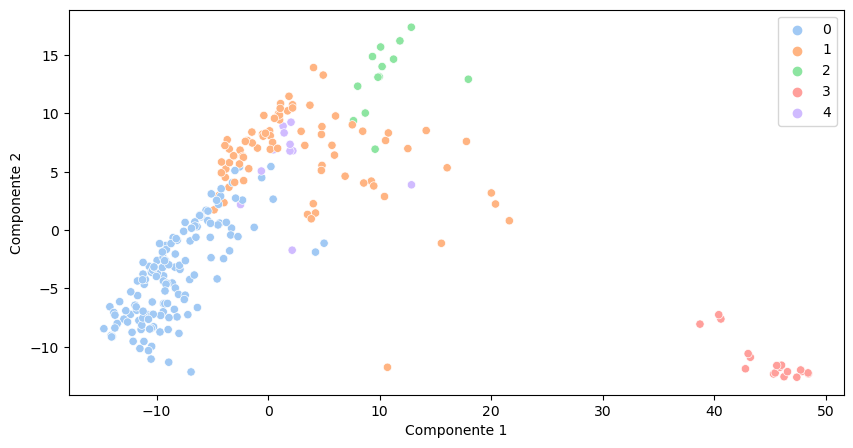

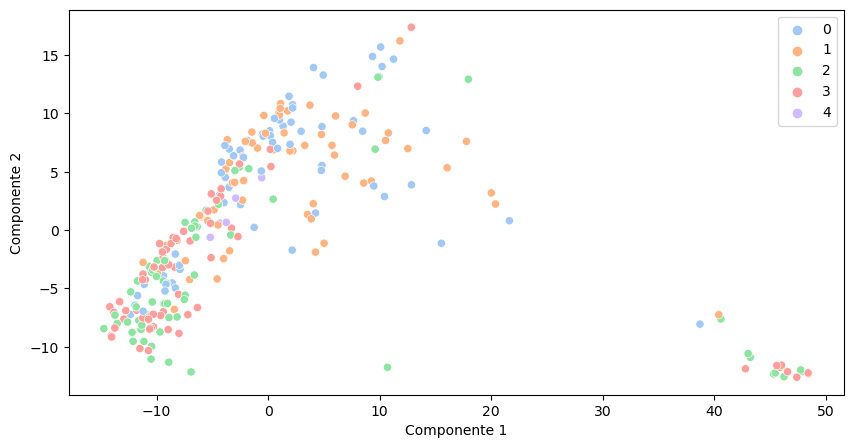

In [70]:
#
# Analisis de clusters
#

# Varianza explicada por el n de componentes
# Con 2 variables explica alrededor de un 50~60% de la varianza a ojo
#plot_pca_variance(Y_flat)

# Nubes de clusters predichas
plot_cluster_clouds([_.flatten()/255 for _ in Y], pred)
# Nubes de clusters reales
plot_cluster_clouds([_.flatten()/255 for _ in Y], y_clusters)

# Imagenes en cada cluster
#draw_clusters(Y, pred) # Si se quieren ver las cartas originales sustituir por Y_imgs

---

<center><h2>CSV</h2></center>

---

In [ ]:
#ids = [y.split("/")[-1][:-4] for y in Y_files]

#solucion = pd.DataFrame(data = { "id" : ids, "suit": pred })
#solucion.to_csv("solucion.csv", index=False)

In [ ]:
#solucion

---

<center><h2>Pruebas</h2></center>

---

In [ ]:
#y = [ Transformator(img).remove_background().img for img in Y_imgs ]
#save_files(y, "../zip/y/", Y_files)

def draw_contours(_img):
    img = _img.copy()
    
    imgGry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gaussian = cv2.GaussianBlur(imgGry,(3,3),cv2.BORDER_DEFAULT)
    edges = cv2.Canny(gaussian,100,200)
    
    #_, treshold = cv2.threshold(imgGry, 127, 255, 0)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #contour = max(contours, key = len)
 #    print(contours[2])

#    print(contour)

    for contour in contours:
        contourImg = cv2.drawContours(img, contour, -1, (0,255,0), 3)
    
    #for contour in contours:
    #    #print(contour)
    #    approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
    #    cv2.drawContours(img, [approx], 0, (0, 0, 0), 2)
    
    return img

#plot_image(draw_contours(X_imgs[104]))

In [ ]:
IMG_SIZE = 224

crop_x1, crop_x2 = 0, 80
crop_y1, crop_y2 = 5, 60

resize_h, resize_w = 40, 40

treshold_empty_space = 10
brightness_lv = 130

# x = [ Transformator(img)
#         #.remove_empty_space(treshold=treshold_empty_space, limit_x=crop_x2, limit_y=crop_y2)
#         #.crop(crop_x1, crop_x2, crop_y1, crop_y2)
#         #.resize(h=resize_h, w=resize_w)
#         .mask(black=([0, 0, 0], [0, 0, 0]))
#         #.remove_channel(0)
#         #.remove_channel(1)
#         #.increase_contrast_brightness(contrast=1, brightness=0)
#         #.equalize_histogram()
#         .img
     
#      for img in X_imgs[:1000]
#]

# x = [ draw_contours(img) for img in Y_imgs ]

# for img in x:
#     for line in img:
#         for i, pixel in enumerate(line):
#             if not (pixel[1] == 255 and pixel[0] == 0 and pixel[2] == 0):
#                 line[i] = [0, 0, 0]

#x = [ Transformator(img).remove_channel(0).remove_channel(1).img for img in x ]
#x = [ Transformator(img).threshold_and().hsv().closing().closing().img for img in X_imgs[:100] ]
#save_files(x, "../zip/asdfasdf/", X_files)

In [ ]:
##################
# Flip if needed #
##################
# img = X_imgs[102]
# #w, h, = img.shape[0], img.shape[1]
# size = 224

# UL = img[0:100, 0:100]
# UR = img[0:100, size-100:size]
# DL = img[size-100:size, 0:100]
# DR = img[size-100:size, size-100:size]

# #UL = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# import statistics as stats

# #plot_image(UL)
# UL = list(UL.flatten())
# mean = stats.variance(UL)
# variance = sum([ abs(mean - x)**2 for x in UL ])/ len(UL)


# print(variance)

In [ ]:
# img = X_imgs[3]

# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# # noise removal
# kernel = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# # sure background area
# sure_bg = cv2.dilate(opening,kernel,iterations=3)

# # Finding sure foreground area
# dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
# ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# # Finding unknown region
# sure_fg = np.uint8(sure_fg)
# unknown = cv2.subtract(sure_bg,sure_fg)

# # Marker labelling
# ret, markers = cv2.connectedComponents(sure_fg)
# # Add one to all labels so that sure background is not 0, but 1
# markers = markers+1
# # Now, mark the region of unknown with zero
# markers[unknown==255] = 0

# markers = cv2.watershed(img,markers)
# img[markers == -1] = [255,0,0]

# plot_image(img)

In [ ]:
#M = cv2.getRotationMatrix2D((112, 112), -45, 0.7)
#rotated = cv2.warpAffine(X_imgs[100], M, (224, 224))
#plot_image(rotated)

In [ ]:
#!pip install Augmentor
#import Augmentor

#pipe = Augmentor.Pipeline("../zip/train/")
#pipe.flip_left_right(probability=0.4)
#pipe.flip_top_bottom(probability=0.8)
#pipe.rotate90(probability=1)
#pipe.skew_tilt(probability=0.01)
#pipe.random_distortion(probability=224, 224, 0.1)
#pipe.shear(probability=0.1)
#pipe.crop_random(1000, 100, probability=0.1)
#pipe.flip_random(probablity=0.05)

#pipe.sample(100)

In [ ]:
#noise = skimage.util.random_noise(X_imgs[1], mode="gaussian", seed=None, clip=True)
#plot_image(noise)

In [ ]:
# #plot_image(X_imgs[100])
# img = X_imgs[18]

# gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# im_gauss = cv2.GaussianBlur(gray_img, (5, 5), 0)
# ret, thresh = cv2.threshold(im_gauss, 127, 255, 0)

# #ret,thresh = cv2.threshold(img,127,255,0)
# #contours,hierarchy = cv2.findContours(thresh, 1, 2)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# #rect = cv2.boundingRect(contours[1])
# #plot_image(rect)
# #print(rect)
# rects = []
# for contour in contours[1:]:
#     area=cv2.contourArea(contour)
#     if area>=200:
#         #cv2.drawContours(frame,[contour],0,(255,0,0),3)
#         x,y,w,h=cv2.boundingRect(contour)
#         rects.append((x, y, w, h))
        
#         #cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)

# #x, y, w, h = rects[0]
# #plot_image(img[y:y+60, x:x+60])
# #print(rects)



In [ ]:
#from sklearn.decomposition import PCA

#plot_image(X_imgs[100].astype(np.uint8) / 255)

# pca = PCA(n_components=50) # TODO: Modify

# #print(X_imgs[0].shape)

# t_imgs = []
# i_imgs = []
# g_imgs = []

# for img in X_imgs[:10]:
#     #b,g,r = cv2.split(img)

#     #b_t = pca.fit_transform(b)
#     #g_t = pca.fit_transform(g)
#     #r_t = pca.fit_transform(r)

#     #b_i = pca.inverse_transform(b_t)
#     #g_i = pca.inverse_transform(g_t)
#     #r_i = pca.inverse_transform(r_t)
    
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray_t = pca.fit_transform(gray)
#     gray_i = pca.inverse_transform(gray_t)

#     g_imgs.append(gray_t)
#     i_imgs.append(gray_i)
    
#     #t_imgs.append( np.dstack((b_t, g_t, r_t)) )
#     #i_imgs.append( np.dstack((b_i, g_i, r_i)).astype(np.uint8) )
    
    
#     #_imgs.append(_img)
#     #_imgs = [ np.dstack(b_[i], g_i[i], r_i[i]) for i in range(len(b_i)) ]

# #display(g_imgs[9])

# plot_image(i_imgs[6])
    
#imgs = [(img.astype(np.uint8)/255).flatten() for img in X_imgs[:100]]
#imgs_reduced   = pca.fit_transform(imgs)
#imgs_recovered = pca.inverse_transform(imgs_reduced)
#print(len(pca.components_))

#fig, ax = plt.subplots(1,1,figsize=(9,3))
#ax.imshow(imgs_recovered[99].reshape(224, 224, 3))

#plt.grid()
#plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
#plt.xlabel('Number of components')
#plt.ylabel('Explained variance')

#print("Explained variance", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
#ax.imshow(imgs_recovered[99].reshape(224, 224, 3))

In [ ]:
#path = "../zip/train/0.jpg"
#img1 = skimage.io.imread(path)
#img2 = cv2.imread(path, cv2.IMREAD_UNCHANGED)

#rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#plot_image(img2)

#print(rgb1)

In [ ]:
img = X_imgs[100]
mask = Transformator(img).mask().img
plot_image(cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask)))